In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('E:/files/Kaggle/New York City Taxi Trip Duration/train.csv')
test = pd.read_csv('E:/files/Kaggle/New York City Taxi Trip Duration/test.csv')
# 打车时间段，打车路段交通情况，天气 ===> 速度
# 路程，速度

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train = train.drop(train[(train['trip_duration'] > 85000)].index)
train = train.drop(train[(train['trip_duration'] < 120)].index)
train['log_trip_duration'] = np.log1p(train['trip_duration'])

In [5]:
# 去除经纬度异常值
train = train.drop(train[(train['dropoff_latitude'] < 40.6)].index)
train = train.drop(train[(train['dropoff_latitude'] > 40.9)].index)
train = train.drop(train[(train['dropoff_longitude'] < -74.05)].index)
train = train.drop(train[(train['dropoff_longitude'] > -73.7)].index)
train = train.drop(train[(train['pickup_latitude'] < 40.6)].index)
train = train.drop(train[(train['pickup_latitude'] > 40.9)].index)
train = train.drop(train[(train['pickup_longitude'] < -74.05)].index)
train = train.drop(train[(train['pickup_longitude'] > -73.7)].index)
city_long_border = (-74.05, -73.7)
city_lat_border = (40.6, 40.9)

<Figure size 1152x720 with 0 Axes>

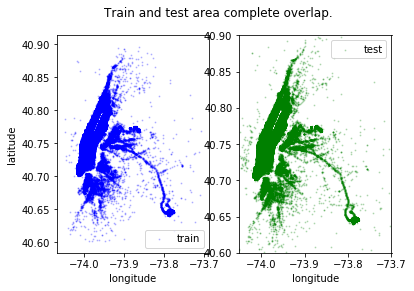

In [6]:
# 上车地点经纬度可视化
plt.figure(figsize=(16, 10))
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:500000], train['pickup_latitude'].values[:500000],
              color='blue', s=1, label='train', marker='o', alpha=0.2)
ax[1].scatter(test['pickup_longitude'].values[:500000], test['pickup_latitude'].values[:500000],
              color='green', s=1, label='test', marker='o', alpha=0.2)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [7]:
# 圆上两点距离
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# 两点间曼哈顿距离
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b


def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values,
                                                    test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values,
                                                                    train['pickup_longitude'].values,
                                                                    train['dropoff_latitude'].values,
                                                                    train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                                   test['pickup_longitude'].values,
                                                                   test['dropoff_latitude'].values,
                                                                   test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values,
                                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values,
                                         test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [8]:
# 寻找时间的关系，几点，星期几，几月
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour

train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

train.loc[:, 'hourofweek'] = train['dayofweek'] * 24 + train['Hour']
test.loc[:, 'hourofweek'] = test['dayofweek'] * 24 + test['Hour']

In [9]:
# 极端天气
weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']
weather_event = pd.Series(pd.to_datetime(weather_event, format='%Y%m%d')).dt.date
train['extreme_weather'] = train.pickup_date.isin(weather_event).map({True: 1, False: 0})
test['extreme_weather'] = test.pickup_date.isin(weather_event).map({True: 1, False: 0})

In [10]:
# 地点与速度聚类，时间段与速度聚类
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

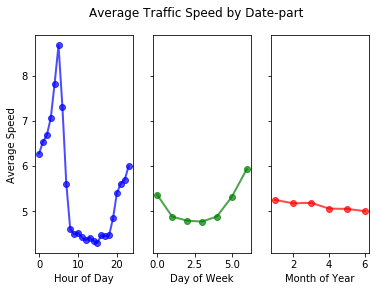

In [11]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_m'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_m'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_m'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

In [12]:
train.groupby('passenger_count').size()

passenger_count
0         12
1    1007471
2     205895
3      58716
4      27805
5      76367
6      47254
9          1
dtype: int64

In [13]:
train[["passenger_count", "trip_duration"]].groupby(['passenger_count'],as_index=False).mean()

,passenger_count,trip_duration
0,0,1169.916667
1,1,858.738656
2,2,912.585410
3,3,908.386232
4,4,924.070994
5,5,911.699608
6,6,914.284442
7,9,560.000000


In [14]:
train[["store_and_fwd_flag", "trip_duration"]].groupby(['store_and_fwd_flag'],as_index=False).mean()

,store_and_fwd_flag,trip_duration
0,N,873.292457
1,Y,1101.391897


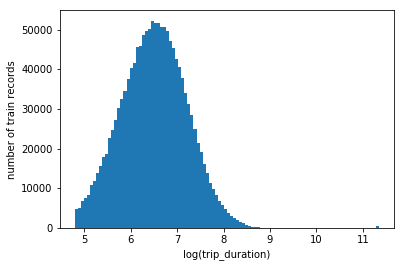

In [15]:
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [16]:
coord_pickup = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                          test[['pickup_latitude', 'pickup_longitude']].values))
coord_dropoff = np.vstack((train[['dropoff_latitude', 'dropoff_longitude']].values,
                           test[['dropoff_latitude', 'dropoff_longitude']].values))

coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=7, batch_size=10000).fit(coords[sample_ind])
for df in (train,test):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

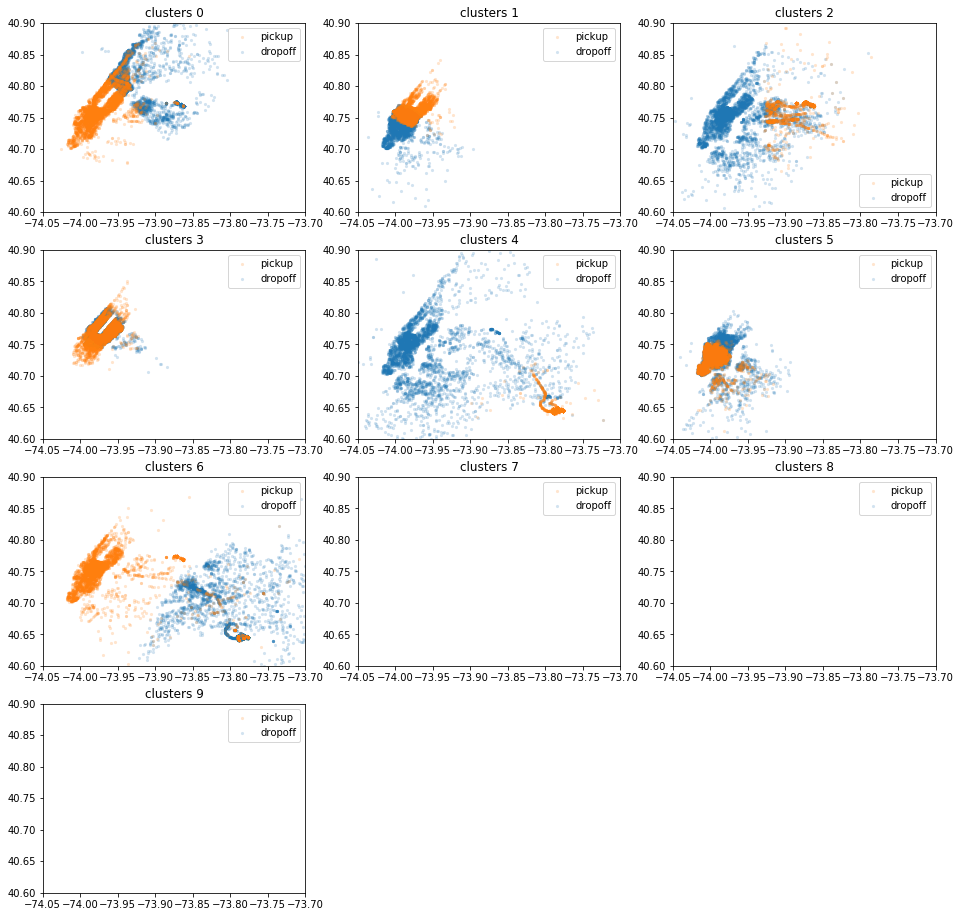

In [17]:
plt.figure(figsize=(16,16))
N = 5000
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = train[train['pickup_dropoff_loc']==i]
    drop = plt.scatter(tmp_data['dropoff_longitude'][:N], tmp_data['dropoff_latitude'][:N], s=10, lw=0, alpha=0.2,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_longitude'][:N], tmp_data['pickup_latitude'][:N], s=10, lw=0, alpha=0.2,label='pickup')    
    plt.xlim(city_long_border);plt.ylim(city_lat_border)
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)

In [18]:
train.groupby('dayofweek').mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]

,avg_speed_h,avg_speed_m,log_trip_duration
dayofweek,,,
0,4.140887,5.356221,6.464986
1,3.770214,4.871598,6.525750
2,3.700248,4.783034,6.548132
3,3.685575,4.761376,6.564552
4,3.770948,4.874535,6.534666
5,4.108960,5.311689,6.455675
6,4.585665,5.924633,6.419096


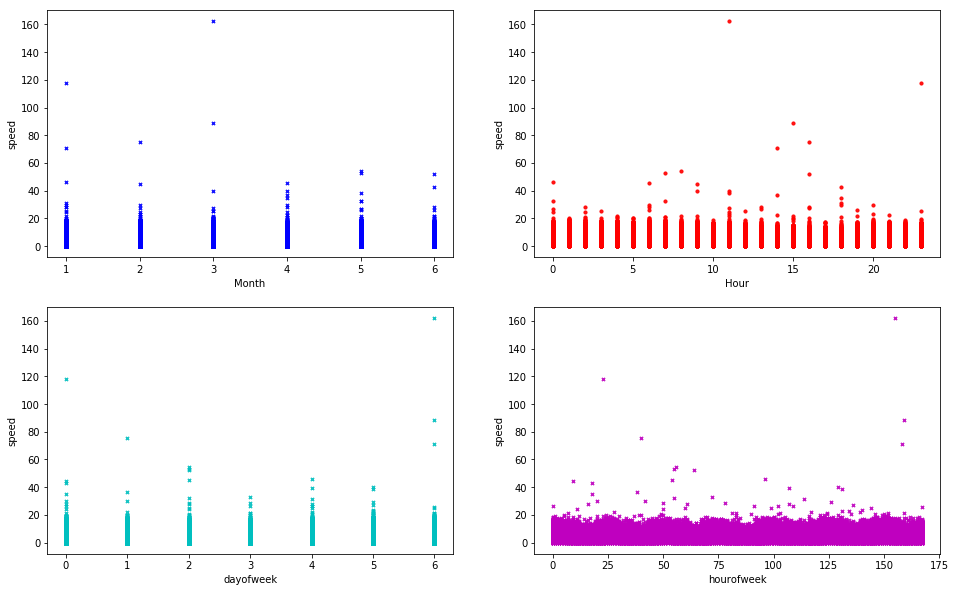

In [19]:
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.scatter(train['Month'].values, train['avg_speed_h'].values,s=10,alpha=0.9,marker='x',color='blue')
plt.xlabel('Month')
plt.ylabel('speed')

plt.subplot(2,2,2)
plt.scatter(train['Hour'].values, train['avg_speed_h'].values,s=10,alpha=0.9,marker='o',color='r')
plt.xlabel('Hour')
plt.ylabel('speed')

plt.subplot(2,2,3)
plt.scatter(train['dayofweek'].values, train['avg_speed_h'].values,s=10,alpha=0.9,marker='x',color='c')
plt.xlabel('dayofweek')
plt.ylabel('speed')

plt.subplot(2,2,4)
plt.scatter(train['hourofweek'].values, train['avg_speed_h'].values,s=10,alpha=0.9,marker='x',color='m')
plt.xlabel('hourofweek')
plt.ylabel('speed')
plt.show()

In [20]:
for gby_col in ['Hour', 'hourofweek',
               'dayofweek', 'pickup_dropoff_loc']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

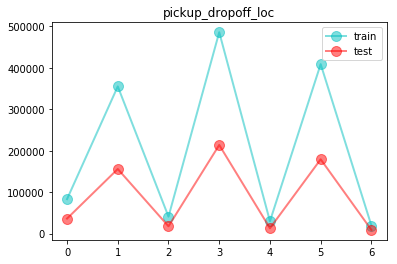

In [21]:
# 由聚类的各类数量比例，观察训练集与测试集的数据分布情况是否相同
plt.plot(train.groupby('pickup_dropoff_loc').count()[['id']], 'o-',ms=10,alpha=0.5,lw=2,label='train',color='c')  
plt.title('pickup_dropoff_loc')

plt.plot(test.groupby('pickup_dropoff_loc').count()[['id']], 'o-',ms=10,alpha=0.5,lw=2,label='test',color='r')  
plt.title('pickup_dropoff_loc')

plt.legend(loc='best')
plt.show()  

In [22]:
print(train.groupby(['pickup_dropoff_loc']).size())
print(test.groupby(['pickup_dropoff_loc']).size())

pickup_dropoff_loc
0     83253
1    355166
2     41029
3    485886
4     29938
5    408868
6     19381
dtype: int64
pickup_dropoff_loc
0     36323
1    155903
2     17708
3    213884
4     13011
5    179349
6      8956
dtype: int64


In [23]:
for gby_cols in [['Hour', 'pickup_dropoff_loc']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [24]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,avg_speed_h_gby_Hour,avg_speed_m_gby_Hour,avg_speed_h_gby_hourofweek,avg_speed_m_gby_hourofweek,avg_speed_h_gby_dayofweek,avg_speed_m_gby_dayofweek,avg_speed_h_gby_pickup_dropoff_loc,avg_speed_m_gby_pickup_dropoff_loc,avg_speed_h_Hour_pickup_dropoff_loc,cnt_Hour_pickup_dropoff_loc
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,3.425928,4.437372,3.568785,4.614677,4.140887,5.356221,3.686928,4.798924,3.348786,29089.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,4.876488,6.272065,4.309569,5.538326,4.585665,5.924633,3.637729,4.648984,4.082625,21182.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,3.406501,4.409037,2.941339,3.803126,3.770214,4.871598,3.462448,4.477327,3.042595,18155.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,3.739803,4.832489,3.603337,4.660134,3.700248,4.783034,3.637729,4.648984,3.358794,25797.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,3.405138,4.408449,3.688956,4.784106,4.108960,5.311689,3.686928,4.798924,3.178226,26773.0


In [25]:
train.columns.values.tolist()

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'log_trip_duration',
 'distance_haversine',
 'distance_dummy_manhattan',
 'direction',
 'pickup_date',
 'Month',
 'Hour',
 'dayofweek',
 'hourofweek',
 'extreme_weather',
 'avg_speed_h',
 'avg_speed_m',
 'pickup_dropoff_loc',
 'avg_speed_h_gby_Hour',
 'avg_speed_m_gby_Hour',
 'avg_speed_h_gby_hourofweek',
 'avg_speed_m_gby_hourofweek',
 'avg_speed_h_gby_dayofweek',
 'avg_speed_m_gby_dayofweek',
 'avg_speed_h_gby_pickup_dropoff_loc',
 'avg_speed_m_gby_pickup_dropoff_loc',
 'avg_speed_h_Hour_pickup_dropoff_loc',
 'cnt_Hour_pickup_dropoff_loc']

In [26]:
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_dropoff_loc']]
df_all

,id,pickup_datetime,pickup_dropoff_loc
0,id2875421,2016-03-14 17:24:55,3
1,id2377394,2016-06-12 00:43:35,5
2,id3858529,2016-01-19 11:35:24,1
3,id3504673,2016-04-06 19:32:31,5
4,id2181028,2016-03-26 13:30:55,3
5,id0801584,2016-01-30 22:01:40,1
6,id1813257,2016-06-17 22:34:59,3
7,id1324603,2016-05-21 07:54:58,3
8,id1301050,2016-05-27 23:12:23,5
9,id0012891,2016-03-10 21:45:01,3


In [28]:
group_freq = '60min'
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
df_counts

,id,count_60min
pickup_datetime,,
2016-01-01 00:00:17,id0190469,1.0
2016-01-01 00:00:22,id0621643,2.0
2016-01-01 00:00:28,id1384355,3.0
2016-01-01 00:00:53,id1665586,4.0
2016-01-01 00:01:01,id1210365,5.0
2016-01-01 00:01:14,id3888279,6.0
2016-01-01 00:01:20,id0924227,7.0
2016-01-01 00:01:24,id2568735,8.0
2016-01-01 00:01:33,id2294362,9.0
